In [167]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
# import custom functions from src/utils.py
import sys
sys.path.append('../')
from src.utils import remove_correlated_features
from src.utils import plot_correlation_heatmap
from src.utils import remove_low_variance_features
from src.utils import plot_pca
from src.utils import plot_feature_importances
from src.utils import confusion_matrix_heatmap

In [168]:
digits = load_digits()

In [169]:
digits.data[2]

array([ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
       14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
        1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
        0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  3., 13., 16.,
       16., 11.,  5.,  0.,  0.,  0.,  0.,  3., 11., 16.,  9.,  0.])

In [170]:
digits.data.shape

(1797, 64)

In [171]:
# convert the data to a pandas dataframe
import pandas as pd
df = pd.DataFrame(digits.data, columns=['feature_' + str(i) for i in range(1, 65)])

# add the target column to the dataframe
df['target'] = digits.target

# check the head of the dataframe
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [172]:
features_df = df.drop('target', axis=1)
target_df = df['target']

In [173]:
features_df.shape

(1797, 64)

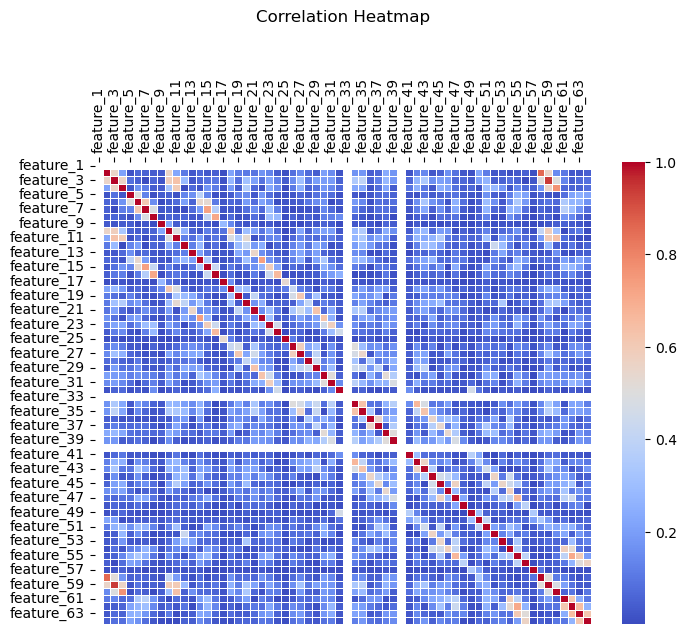

In [174]:
plot_correlation_heatmap(features_df, annot=False)

In [175]:
features_df = remove_correlated_features(features_df, 0.9)
features_df.head()
print(features_df.shape)

(1797, 63)


In [176]:
# Check for balance in the target variable
target_df.value_counts()

target
3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64

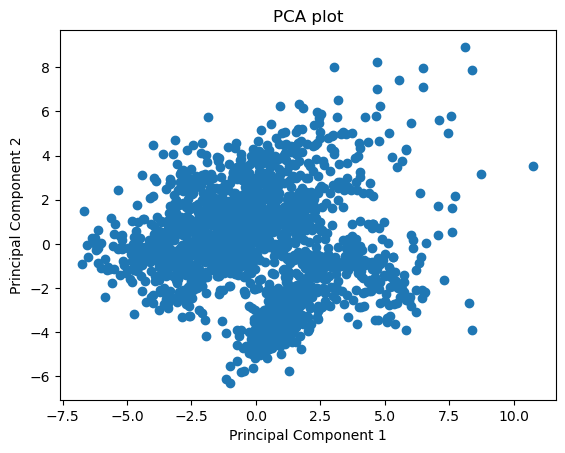

In [177]:
plot_pca(features_df)

In [178]:
features_df = remove_low_variance_features(features_df, 0.01)
print(features_df.shape)
features_df.head()

(1797, 48)


,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_11,feature_12,feature_13,...,feature_52,feature_53,feature_54,feature_55,feature_58,feature_60,feature_61,feature_62,feature_63,feature_64
0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,13.0,15.0,10.0,...,5.0,10.0,12.0,0.0,0.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,11.0,16.0,...,16.0,16.0,6.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,4.0,15.0,12.0,0.0,0.0,3.0,16.0,15.0,...,16.0,16.0,11.0,5.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,7.0,15.0,13.0,1.0,0.0,8.0,13.0,6.0,15.0,...,4.0,5.0,14.0,9.0,0.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,7.0,8.0,...,3.0,15.0,10.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [179]:
# Scale the features using MaxMinScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features_df = scaler.fit_transform(features_df)

In [180]:
X = scaled_features_df
y = target_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:

# Use logistic regression to classify the data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000, multi_class='auto',  solver='lbfgs', tol=0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9666666666666667


<h2 style="color:blue" align="center">Model Selection, Feature Engineering and Hyperparameter Optimization</h2>

In this section, I seek to select the best model, features (and/or feature combinations) and hyperparameters. This section will include:
<ol>
    <li>K-fold Cross Validation</li>
    <li>Feature Engineering (Selecting the best combination of features using selectKBest)</li>
    <li>Hyperparameter Optimization (Bayesian Optimization using hyperopt) </li>
</ol>

In [182]:
# Search space containing models and their hyperparameters
search_space = {
    'model': hp.choice('model', [
        {
            'type': 'RandomForestClassifier',
            'n_estimators': scope.int(hp.quniform('rf_n_estimators', 50, 300, 10)), 
            'max_depth': scope.int(hp.quniform('rf_max_depth', 3, 20, 1)),  
            'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]), 
        },
        {
            'type': 'LogisticRegression',
            'C': hp.uniform('lr_C', 0.1, 1.0),
        },
        {
            'type': 'XGBClassifier',
            'n_estimators': scope.int(hp.quniform('xgb_n_estimators', 50, 300, 10)),
            'max_depth': scope.int(hp.quniform('xgb_max_depth', 3, 10, 1)),
            'learning_rate': hp.uniform('xgb_learning_rate', 0.01, 0.3),
        },
        {
            'type': 'LGBMClassifier',
            'n_estimators': scope.int(hp.quniform('lgbm_n_estimators', 50, 300, 10)),
            'max_depth': scope.int(hp.quniform('lgbm_max_depth', -1, 20, 1)), 
            'learning_rate': hp.uniform('lgbm_learning_rate', 0.01, 0.3),
            'num_leaves': scope.int(hp.quniform('lgbm_num_leaves', 20, 40, 1)),
        },
        {
            'type': 'CatBoostClassifier',
            'iterations': scope.int(hp.quniform('cat_iterations', 50, 300, 10)),
            'depth': scope.int(hp.quniform('cat_depth', 3, 10, 1)),
            'learning_rate': hp.uniform('cat_learning_rate', 0.01, 0.3),
        },
        {
            'type': 'GaussianNB',
        },
        {
            'type': 'KNeighborsClassifier',
            'n_neighbors': scope.int(hp.quniform('knn_n_neighbors', 3, 15, 1)),
            'weights': hp.choice('knn_weights', ['uniform', 'distance']),
        },
        {
            'type': 'DecisionTreeClassifier',
            'max_depth': scope.int(hp.quniform('dt_max_depth', 3, 20, 1)),
            'min_samples_split': scope.int(hp.quniform('dt_min_samples_split', 2, 10, 1)),
        },
        {
            'type': 'AdaBoostClassifier',
            'n_estimators': scope.int(hp.quniform('ada_n_estimators', 50, 300, 10)),
            'learning_rate': hp.uniform('ada_learning_rate', 0.01, 1.0),
        },
        {
            'type': 'GradientBoostingClassifier',
            'n_estimators': scope.int(hp.quniform('gb_n_estimators', 50, 300, 10)),
            'learning_rate': hp.uniform('gb_learning_rate', 0.01, 0.3),
            'max_depth': scope.int(hp.quniform('gb_max_depth', 3, 10, 1)),
        },
        {
            'type': 'ExtraTreesClassifier',
            'n_estimators': scope.int(hp.quniform('et_n_estimators', 50, 300, 10)),
            'max_depth': scope.int(hp.quniform('et_max_depth', 3, 20, 1)),
            'max_features': hp.choice('et_max_features', ['sqrt', 'log2', None]),
        },
    ]),
    'polynomialfeatures_degree': hp.choice('polynomialfeatures_degree', range(1, 3)),
    'selectkbest_k': hp.choice('selectkbest_k', range(1, 49)), # the features are 48 after removing correlated features
}

In [183]:

# Objective function to minimize
def objective(params):
    model_name = params['model']['type']
    del params['model']['type']
    
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params['model'])
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(**params['model'], max_iter=1000)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**params['model'])
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(**params['model'],verbosity=-1)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(**params['model'], verbose=False)
    elif model_name == 'GaussianNB':
        model = GaussianNB()
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(**params['model'])
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params['model'])
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(**params['model'])
    elif model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(**params['model'])
    elif model_name == 'ExtraTreesClassifier':
        model = ExtraTreesClassifier(**params['model'])

    model_pipeline = make_pipeline(
        PolynomialFeatures(degree=params['polynomialfeatures_degree']),
        SelectKBest(f_regression, k=params['selectkbest_k']),
        model
    )
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss')
    log_loss_cv = -scores.mean() 
    
    return {
        'loss': log_loss_cv,
        'status': STATUS_OK,
        'model_pipeline': model_pipeline,
    }

trials = Trials()
best = fmin(objective, search_space, algo=tpe.suggest, max_evals=150, trials=trials)

100%|██████████| 150/150 [29:13<00:00, 11.69s/trial, best loss: 0.08990393687302248] 


In [184]:
best_params = space_eval(search_space, best)
best_params

{'model': {'depth': 6,
  'iterations': 290,
  'learning_rate': 0.2825407528732751,
  'type': 'CatBoostClassifier'},
 'polynomialfeatures_degree': 2,
 'selectkbest_k': 46}

<h2 style="color:blue" align="center">Model Re-training, Inference, Evaluation and Saving</h2>

In this section, I will re-train with the best model and hyper-paramaters from the previous secction. This section will include:
<ol>
    <li>Model Re-training</li>
    <li>Feature Importance</li>
    <li>Model Saving</li>
</ol>

In [185]:
best_params['model']

{'depth': 6,
 'iterations': 290,
 'learning_rate': 0.2825407528732751,
 'type': 'CatBoostClassifier'}

In [186]:
# Rebuild the pipeline with the best parameters
best_model_name = best_params['model']['type']
del best_params['model']['type']

if best_model_name == 'RandomForestClassifier':
    best_model = RandomForestClassifier(**best_params['model'])
elif best_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**best_params['model'])
elif best_model_name == 'XGBClassifier':
    best_model = XGBClassifier(**best_params['model'])
elif best_model_name == 'LGBMClassifier':
    best_model = LGBMClassifier(**best_params['model'],verbosity=-1, force_row_wise=True)
elif best_model_name == 'CatBoostClassifier':
    best_model = CatBoostClassifier(**best_params['model'], verbose=False)
elif best_model_name == 'GaussianNB':
    best_model = GaussianNB()
elif best_model_name == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier(**best_params['model'])
elif best_model_name == 'DecisionTreeClassifier':
    best_model = DecisionTreeClassifier(**best_params['model'])
elif best_model_name == 'AdaBoostClassifier':
    best_model = AdaBoostClassifier(**best_params['model'])
elif best_model_name == 'GradientBoostingClassifier':
    best_model = GradientBoostingClassifier(**best_params['model'])
elif best_model_name == 'ExtraTreesClassifier':
    best_model = ExtraTreesClassifier(**best_params['model'])


# Create the pipeline with the best parameters
best_model_pipeline = make_pipeline(
    PolynomialFeatures(degree=best_params['polynomialfeatures_degree']),  # Use the best degree
    SelectKBest(f_regression, k=best_params['selectkbest_k']),  # Use the best k features
    best_model
)

In [187]:
# Fit the pipeline on the full training data
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest',
                 SelectKBest(k=46,
                             score_func=<function f_regression at 0x00000298F7F084C0>)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x00000298FCB91580>)])

In [188]:
best_model_pipeline.score(X_test, y_test)

0.9722222222222222

In [189]:
y_pred = best_model_pipeline.predict(X_test)

In [190]:
selected_features_indices = best_model_pipeline.named_steps['selectkbest'].get_support(indices=True)
poly = best_model_pipeline.named_steps['polynomialfeatures']
transformed_feature_names = poly.get_feature_names_out(input_features=features_df.columns)
# map the selected indices to the transformed feature names
selected_features = transformed_feature_names[selected_features_indices]
selected_features

array(['feature_53', 'feature_4 feature_53', 'feature_11 feature_28',
       'feature_11 feature_29', 'feature_11 feature_36',
       'feature_12 feature_53', 'feature_13^2', 'feature_13 feature_52',
       'feature_13 feature_53', 'feature_13 feature_54',
       'feature_13 feature_61', 'feature_14 feature_28',
       'feature_14 feature_34', 'feature_14 feature_36',
       'feature_19 feature_28', 'feature_19 feature_29',
       'feature_19 feature_36', 'feature_20 feature_53',
       'feature_21 feature_53', 'feature_22 feature_28',
       'feature_22 feature_29', 'feature_22 feature_34',
       'feature_22 feature_36', 'feature_23 feature_29',
       'feature_26 feature_39', 'feature_26 feature_43',
       'feature_27 feature_29', 'feature_28 feature_30',
       'feature_29 feature_30', 'feature_29 feature_31',
       'feature_29 feature_38', 'feature_29 feature_39',
       'feature_30 feature_36', 'feature_31 feature_43',
       'feature_34 feature_51', 'feature_34 feature_54',
  

In [191]:
# Get the feature importances
if best_model_name == 'RandomForestClassifier':
    feature_importances = best_model_pipeline.named_steps['randomforestclassifier'].feature_importances_
elif best_model_name == 'XGBClassifier':
    feature_importances = best_model_pipeline.named_steps['xgbclassifier'].feature_importances_
elif best_model_name == 'LGBMClassifier':
    feature_importances = best_model_pipeline.named_steps['lgbmclassifier'].feature_importances_
elif best_model_name == 'CatBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['catboostclassifier'].feature_importances_
elif best_model_name == 'DecisionTreeClassifier':
    feature_importances = best_model_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
elif best_model_name == 'AdaBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['adaboostclassifier'].feature_importances_
elif best_model_name == 'GradientBoostingClassifier':
    feature_importances = best_model_pipeline.named_steps['gradientboostingclassifier'].feature_importances_
elif best_model_name == 'ExtraTreesClassifier':
    feature_importances = best_model_pipeline.named_steps['extratreesclassifier'].feature_importances_

feature_importances
# map the feature importances to the selected features
selected_features_importances = pd.Series(feature_importances, index=selected_features)
# Sort the features by importance
selected_features_importances = selected_features_importances.sort_values(ascending=False)
selected_features_importances

feature_22 feature_28    8.905242
feature_31 feature_43    6.605476
feature_19 feature_28    6.081509
feature_13 feature_54    5.744087
feature_11 feature_29    5.610925
feature_27 feature_29    4.645829
feature_29 feature_39    4.639689
feature_20 feature_53    4.058522
feature_13 feature_52    3.976041
feature_52 feature_61    3.569055
feature_53 feature_62    3.227822
feature_14 feature_28    2.910337
feature_36 feature_46    2.777920
feature_51 feature_53    2.547205
feature_21 feature_53    2.179371
feature_29 feature_38    1.831303
feature_13 feature_53    1.817159
feature_23 feature_29    1.735257
feature_29 feature_31    1.712962
feature_22 feature_36    1.645181
feature_11 feature_28    1.587885
feature_30 feature_36    1.555848
feature_34 feature_54    1.490722
feature_26 feature_43    1.453565
feature_29 feature_30    1.417826
feature_19 feature_36    1.384664
feature_22 feature_29    1.375170
feature_53 feature_60    1.327185
feature_22 feature_34    1.301660
feature_53^2  

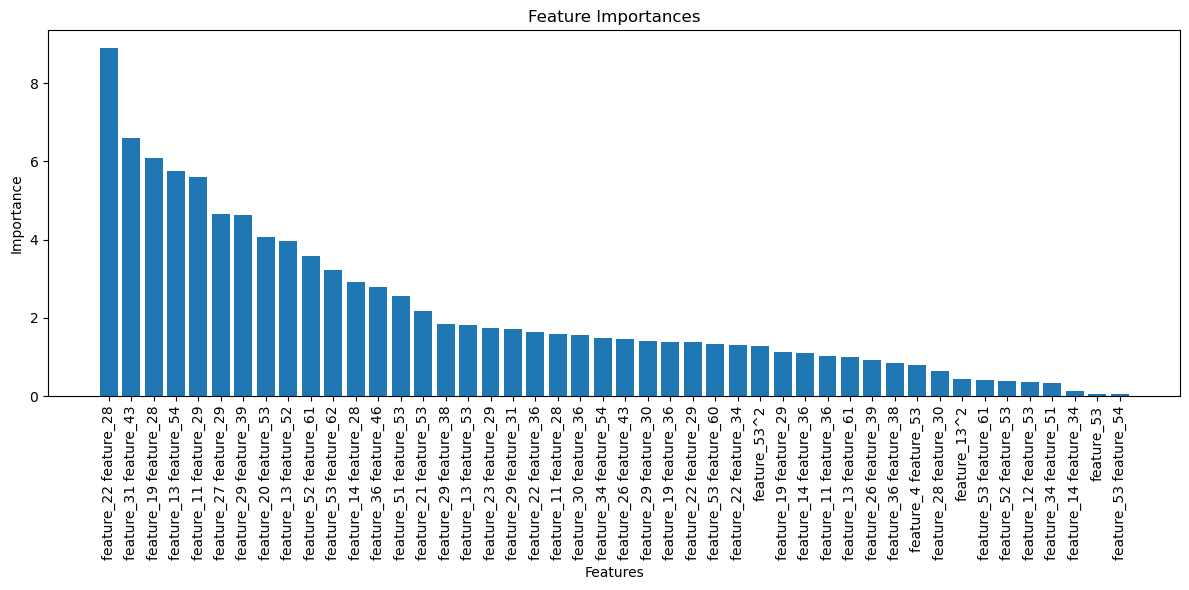

In [192]:
plot_feature_importances(feature_importances, selected_features)

<h2 style="color:blue" align="center">Model Performance Metrics</h2>

In this section, I seek to access and discuss the performance of the model. This section will include:
<ol>
    <li>Confussion Matrix</li>
    <li>Classification Report</li>
</ol>

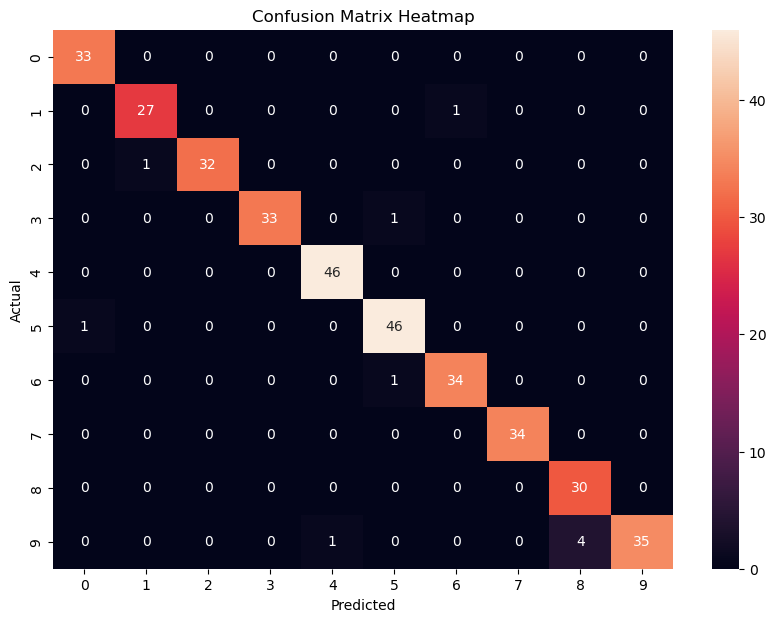

In [193]:
confusion_matrix_heatmap(y_test, y_pred)

**Most of the off-diagonal elements are zeros, which shows that the predicted differs from the acctual on <br> very few occasions, indicating that the model performed well.** 

In [194]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.96      0.96      0.96        28
           2       1.00      0.97      0.98        33
           3       1.00      0.97      0.99        34
           4       0.98      1.00      0.99        46
           5       0.96      0.98      0.97        47
           6       0.97      0.97      0.97        35
           7       1.00      1.00      1.00        34
           8       0.88      1.00      0.94        30
           9       1.00      0.88      0.93        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360

